# Audio MNIST Classifier

The MNIST digit classifier is a standard "Hello world" program for getting started with PyTorch and deep learning. I reccently applied to some jobs at Dolby and realized that I hadn't done anything with audio! Of course I soon discovered that there is a similar "Hello world" project in the world of audio learning: Audio MNIST. 

The Audio MNIST dataset consists of 60 speakers saying each of the 10 digits 0 - 9 50 times each. The audio is recorded at 48kHz and the samples are all less than a second long.

This notebook goes through a convolutional classifier to tackle this dataset. We easily obtain better than 97% accuracy on our testing set.

I used Ketan Doshi's [tutorial](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5) as a jumping off point for my explorations.

### References:
1. [**Interpreting and Explaining Deep Neural Networks for Classification of Audio Signals**](https://arxiv.org/abs/1807.03418). S. Becker, M. Ackermann, S. Lapuschkin, K.R. Müller, and S. Wojciech. ArXiV preprint. 2018
2. [**Audio Deep Learning Made Simple: Sound Classification, Step-by-Step**](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5), K. Doshi. Towards Data Science. 2021.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torchaudio
#from scipy.io import wavfile as wv
import torch
import torch.nn as nn
from tqdm import tqdm # progress bar
import librosa
import numpy as np
import os

In [2]:
DATAPATH = '../Datasets/audio/'
DATAPATH2 = '../Datasets/'

Use CUDA device

In [3]:
if torch.cuda.is_available():
    print("Using CUDA device")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device('cpu')

Using CPU


## Preprocessing Pipeline

We are going to build 2D sepctrograms from the 1D audio channel, and then use a 2D CNN to learn from these spectrograms.

In [4]:
import random

import torch
import torchaudio
from torchaudio import transforms


class AudioHandler:
    @staticmethod
    def open(file_path):
        # throw away sample rate since it is a constant
        signal, _ = torchaudio.load(file_path)
        return signal

    @staticmethod
    def pad(signal, audio_length):
        new_signal = torch.zeros((1, audio_length))
        new_signal[0, 0:len(signal)] = signal
        return new_signal

    @staticmethod
    def time_shift(signal, shift_limit):
        """ Data augmentation: shift forward or back by a bit. """
        signal_length = signal.shape[1]
        shift = int(random.random() * shift_limit * signal_length)
        return signal.roll(shift)

    @staticmethod
    def spectrogram(signal, n_mels=64, n_fft=2034, hop_len=None, mfcc=True, n_mfcc=20):
        top_db = 80

        if mfcc:
            melkwargs = {"n_fft": n_fft,
                         "hop_length": hop_len,
                         "n_mels": n_mels,
                         "center": False}
            spec = transforms.MFCC(sample_rate=48000,
                                   n_mfcc=n_mfcc,
                                   melkwargs=melkwargs)(signal)
            spec = spec[:, 1:, :]

        else:
            spec = transforms.MelSpectrogram(sample_rate=48000, n_fft=n_fft,
                                             hop_length=hop_len,
                                             n_mels=n_mels)(signal)
            spec = transforms.AmplitudeToDB(top_db=top_db)(torch.Tensor(spec))

        return spec

    @staticmethod
    def spectral_augmentation(spec, max_mask_ptc=0.1,
                              n_freq_masks=1,
                              n_time_masks=1):
        """ Augment the spectrogram data. """
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_ptc * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(
                freq_mask_param
            )(aug_spec, mask_value)

        time_mask_param = max_mask_ptc * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(
                time_mask_param
            )(aug_spec, mask_value)

        return aug_spec


## Constructing the DataSet and DataLoader

The dataset is fairly large and it is actaually more convinent to not store the entire dataset in memory (at least on Kaggle). Instead we create an indexed dictionary of the filenames and load only a batch at a time into memory.

When we create the dataloaders we will use multiple workers which will speed up training since each bactch will be loaded prior to training beginning.

In [5]:
import math
def compress(x):
    n = x.size(0)
    assert math.floor(n / 8) * 8 == n
    size = x.size()
    x = x.reshape((math.floor(n / 8), 8, *size[1:]))
    x = x.swapaxes(0, 1)
    y = 0
    for i in range(8):
        y = y * 2 + x[i]
    return y


def decompress(x):
    n = x.size(0)
    ans = []
    for i in range(8):
        ans.append(x & 1)
        x = x >> 1
    ans.reverse()
    return torch.stack(ans).swapaxes(0, 1).reshape((n * 8, *x.size()[1:]))

In [6]:
class DataPreprocess:
    def __init__(self, datapath, visualization=False, spkgen=None, mfcc=True, augment=False):
        self.datapath = datapath
        self.audio_len = 48000
        self.shift_ptc = 0.4
        self.visualization = visualization
        self.spkgen = spkgen
        self.mfcc = mfcc
        self.augment = augment
        self.files = self._build_files()
        self.data = self._build_data()

    def _build_files(self):
        print('start building files!')
        files = {i: [] for i in range(10)}
        for ii in range(1, 61):
            num = "0%d" % ii if ii < 10 else "%d" % ii
            for jj in range(50):
                for kk in range(10):
                    files[kk].append(
                        self.datapath + num + "/%d_%s_%d.wav" % (
                            kk, num, jj))

        return files

    def _build_data(self):
        print('start building data!')
        data = {i: [[] for _ in range(4)] for i in range(10)}

        for i in tqdm(range(10)):
            for file in self.files[i]:
                signal = AudioHandler.open(file)[0]
                pad = AudioHandler.pad(signal, self.audio_len)
                # shift = AudioHandler.time_shift(pad, self.shift_ptc)
                shift = pad
                sgram = AudioHandler.spectrogram(
                    shift, n_mels=64, n_fft=1024, hop_len=None, mfcc=self.mfcc
                )
                if self.augment:
                    sgram = AudioHandler.spectral_augmentation(
                        sgram, max_mask_ptc=0.1, n_freq_masks=2, n_time_masks=2
                    )

                sgram = sgram[0]
                padded = torch.sum(sgram, 0) > 1e-3
                sgram = ((sgram.T - torch.mean(sgram, 1)) / torch.std(sgram, 1)).T
                sgram = sgram * padded - 3 * (1 - 1 * padded)

                spkgen = self.spkgen
                spk = spkgen.transform(0, sgram.unsqueeze(0)).permute(1, 2, 0)[0]
                data[i][0].append(signal)
                data[i][1].append(pad)
                data[i][2].append(sgram)
                data[i][3].append(spk)

        return data

    def __len__(self):
        return 30000

    def __getitem__(self, idx):
        file = self.files[idx // 3000][idx % 3000]
        signal = AudioHandler.open(file)[0]
        pad = AudioHandler.pad(signal, self.audio_len)
        # shift = AudioHandler.time_shift(pad, self.shift_ptc)
        shift = pad
        sgram = AudioHandler.spectrogram(
            shift, n_mels=64, n_fft=1024, hop_len=None, mfcc=self.mfcc
        )
        if self.augment:
            sgram = AudioHandler.spectral_augmentation(
                sgram, max_mask_ptc=0.1, n_freq_masks=2, n_time_masks=2
            )

        sgram = sgram[0]
        padded = torch.sum(sgram, 0) > 1e-3
        sgram = ((sgram.T - torch.mean(sgram, 1)) / torch.std(sgram, 1)).T
        sgram = sgram * padded - 3 * (1 - 1 * padded)

        spkgen = self.spkgen
        spk = spkgen.transform(0, sgram.unsqueeze(0)).permute(1, 2, 0)[0]

        if self.visualization:
            self.plot(signal, pad, sgram, spk)

        return spk, self.files[idx][1]

    def plot(self, signal, pad, sgram, spk):
        fig, axs = plt.subplots(4, figsize=[20, 25])
        axs[0].plot(np.arange(len(signal)), np.array(signal))
        axs[0].set_title('Original Signal')
        axs[0].set_xlabel('time')

        axs[1].plot(np.arange(len(pad[0])), np.array(pad[0]))
        axs[1].set_title('Padded Signal')
        axs[1].set_xlabel('time')

        img = librosa.display.specshow(np.array(sgram), sr=48000, ax=axs[2])
        title3 = 'MFCC' if self.mfcc else 'Mel Spectrogram'
        axs[2].set_title(title3)
        axs[2].set_xlabel('timestep')
        fig.colorbar(img, ax=axs[2], format="%+2.f")

        img = librosa.display.specshow(np.array(spk), sr=48000, ax=axs[3])
        title3 = 'spikes'
        axs[3].set_title(title3)
        axs[3].set_xlabel('timestep')
        fig.colorbar(img, ax=axs[3], format="%+2.f")

    def preprocess(self):
        print('start storing spike files!')
        spks = [[] for _ in range(10)]

        for i in tqdm(range(10)):
            spks[i] = torch.stack(self.data[i][3])
            #spks[i] = torch.permute(spks[i], (1, 0, 2))

            output = compress(spks[i].byte())
            torch.save(output.byte(), self.datapath[:-6] + str(i) + '_dataset.pth')

        return spks

In [7]:
class SpikeGenerator:

    def __init__(self, step, scale, sp, sn, decay):
        self.step = step
        self.scale = scale
        self.sp = sp
        self.sn = sn
        self.decay = decay

    def transform(self, _, x):
        x = x.permute(2, 0, 1)
        max_t, batch_size, channel = x.size()
        x = torch.clamp((x + self.sn) / (self.sp + self.sn), 0, 1) * self.scale
        mem = torch.zeros((batch_size, channel))
        record = []
        for t in range(max_t):
            mem = (mem + x[t]) * self.decay
            out = 1 * (mem > 1)
            mem = mem - out
            record.append(out)
        ans = torch.concat((torch.stack(record), torch.zeros((self.step - max_t, batch_size, channel))), dim=0)
        return ans


In [8]:
from torch.utils.data import DataLoader, Dataset, random_split

class AudioMNIST(Dataset):
    def __init__(self, datapath, visualization=False):
        self.datapath = datapath
        self.visualization = visualization
        self.data = self._rebuild_data()

    def _rebuild_data(self):
        print('rebuilding data!')
        data = {i: [] for i in range(10)}

        for i in tqdm(range(10)):
            sample = torch.load(self.datapath + str(i) + '_dataset.pth')
            data[i].append(decompress(sample))

        return data

    def __len__(self):
        return 30000

    def __getitem__(self, idx):
        if self.visualization:
            fig, ax = plt.subplots()
            img = librosa.display.specshow(self.data[idx], sr=48000, ax=ax)
            ax.set_title('spikes')
            ax.set_xlabel('timestep')
            fig.colorbar(img, ax=ax, format="%+2.f")

        return self.data[idx // 3000][idx % 3000], idx//3000


class DataParam:
    def __init__(self, ratio, batch_size, shuffle):
        """
        @param ratio: the ratio of the length of subset of data to the dataset
        @param batch_size: size of the batch
        @param shuffle: T/F
        """
        self.ratio = ratio
        self.batch_size = batch_size
        self.shuffle = shuffle


class LoaderCreator:
    def __init__(self, datapath, mfcc=True, num_workers=2):
        """
        @param datapath: the path to dataset
        @param num_workers:
        """
        self.num_workers = num_workers
        self.dataset = AudioMNIST(datapath)

    def create_loaders(self, train_param: DataParam, val_param: DataParam, test_param: DataParam):
        train_ds, val_ds, test_ds = random_split(self.dataset, [train_param.ratio, val_param.ratio, test_param.ratio])
        train_dl = DataLoader(train_ds,
                              batch_size=train_param.batch_size,
                              shuffle=train_param.shuffle,
                              num_workers=self.num_workers)
        val_dl = DataLoader(val_ds,
                            batch_size=val_param.batch_size,
                            shuffle=val_param.shuffle,
                            num_workers=self.num_workers)
        test_dl = DataLoader(test_ds,
                             batch_size=test_param.batch_size,
                             shuffle=test_param.shuffle,
                             num_workers=self.num_workers)
        return train_dl, val_dl, test_dl


In [9]:
spks = DataPreprocess(DATAPATH, spkgen=SpikeGenerator(128, 1, 3, 1, 0.9)).preprocess()

start building files!
start building data!


100%|██████████| 10/10 [02:45<00:00, 16.59s/it]


start storing spike files!


100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 136.39it/s]


tensor(0)
rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 156.98it/s]


tensor(0)
rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 159.20it/s]


tensor(0)
rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 169.63it/s]


tensor(0)
rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 171.68it/s]


tensor(0)
rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 158.48it/s]

tensor(0)


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 167.58it/s]


tensor(0)
rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 186.90it/s]

tensor(0)


rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 171.09it/s]


tensor(0)
rebuilding data!


100%|██████████| 10/10 [00:00<00:00, 164.97it/s]


tensor(0)


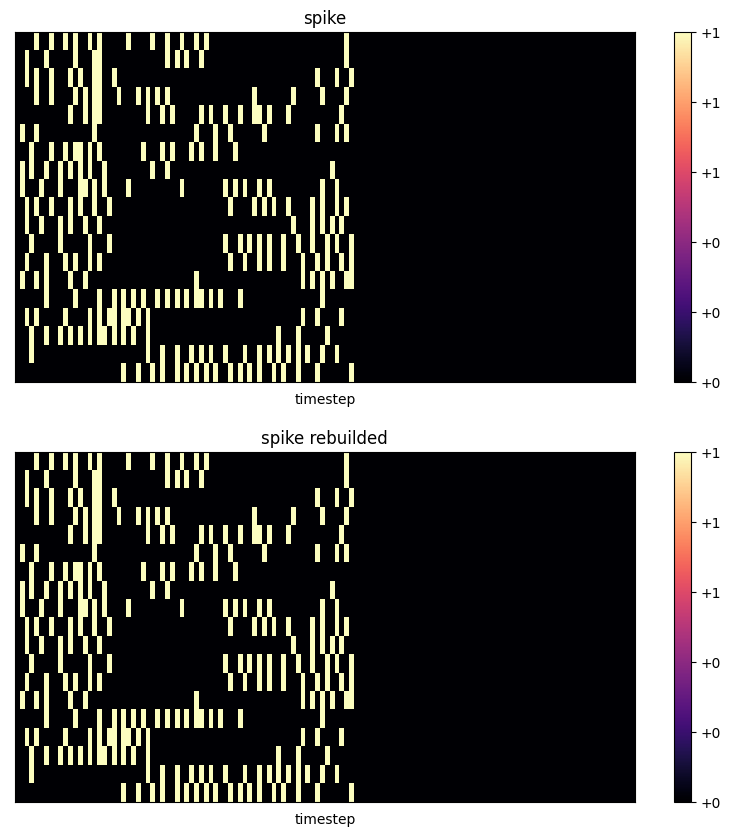

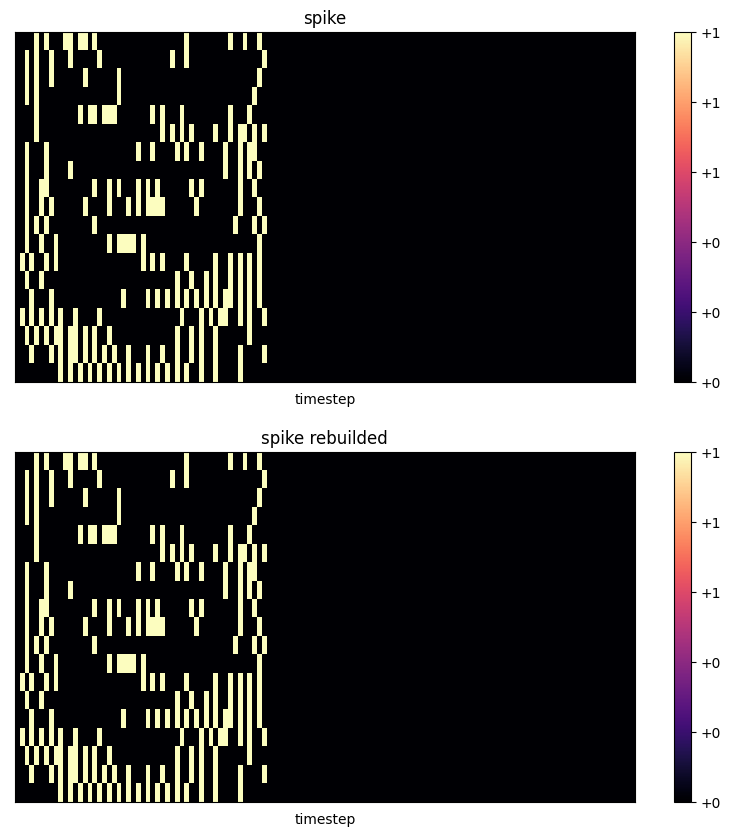

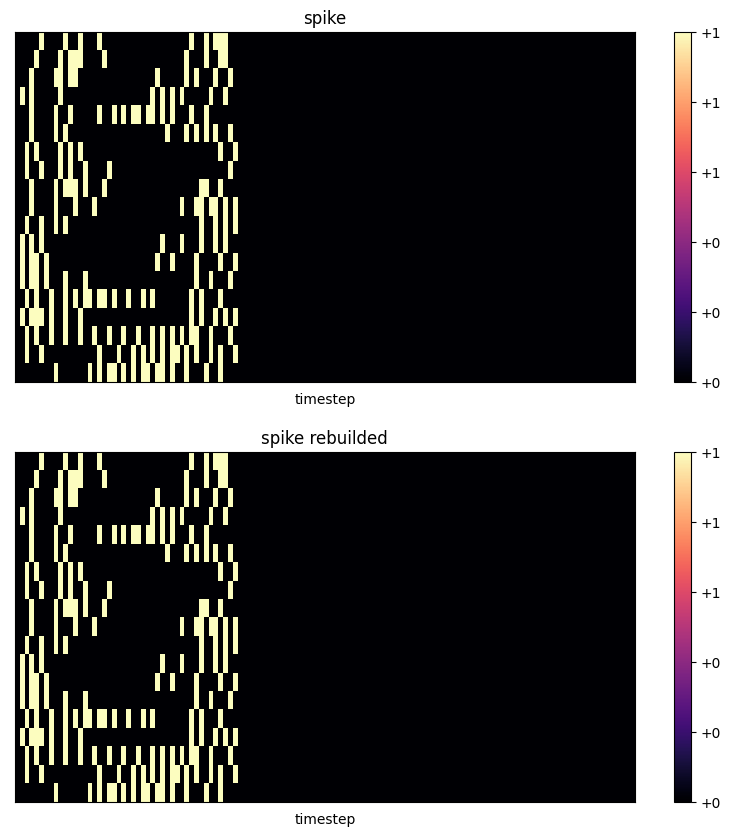

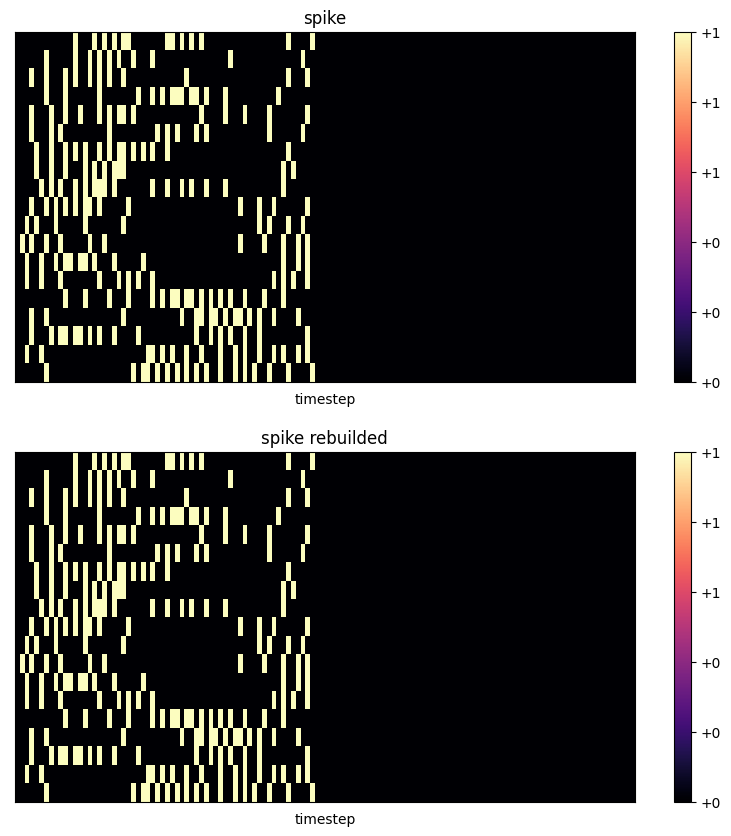

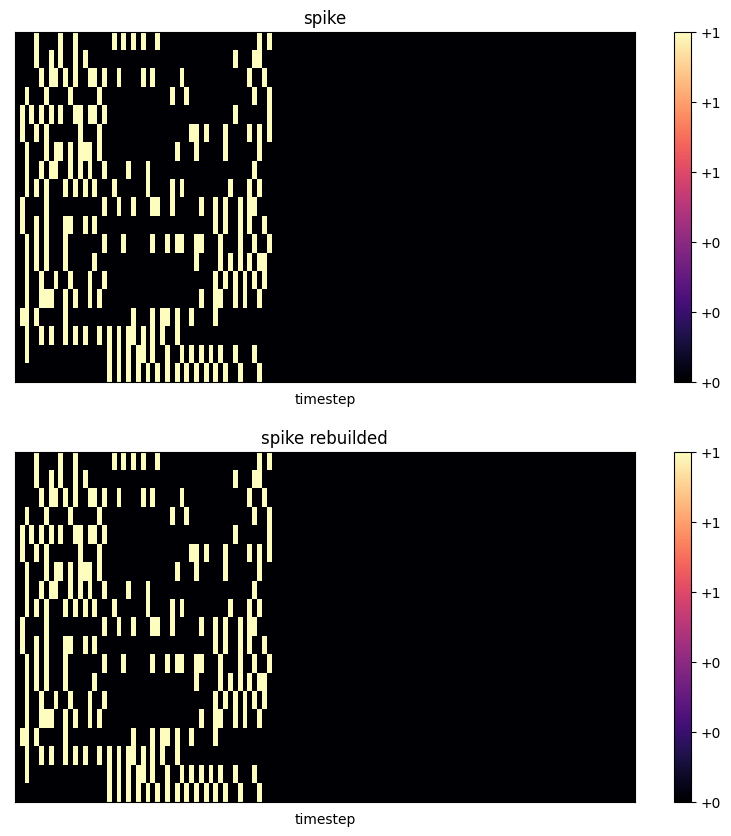

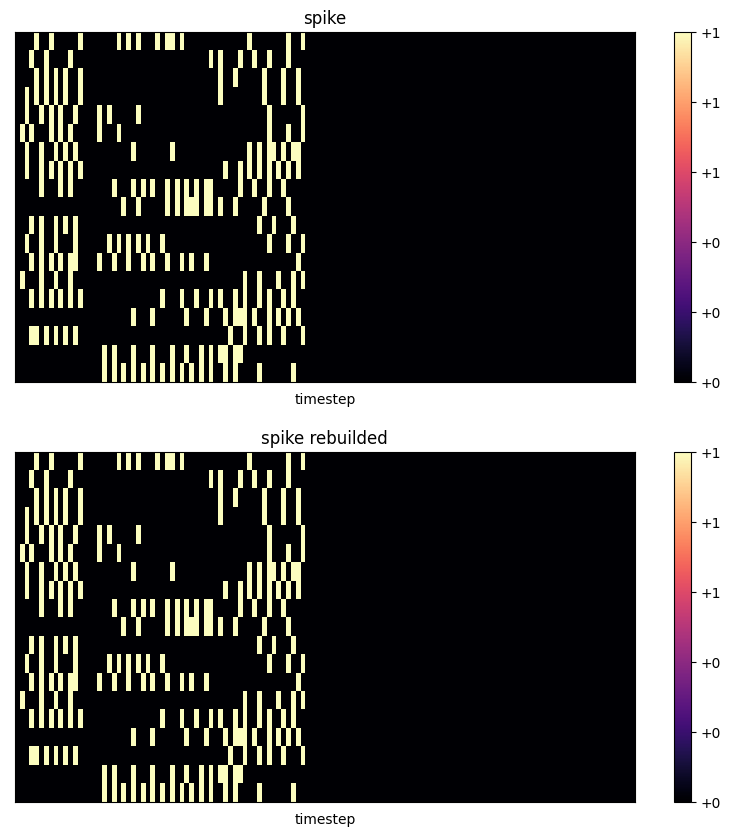

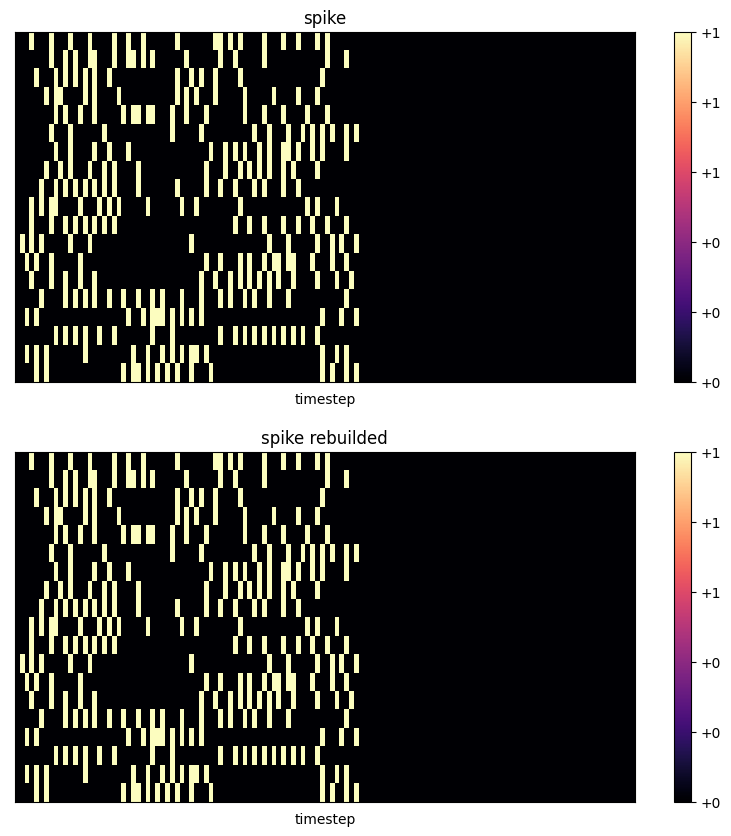

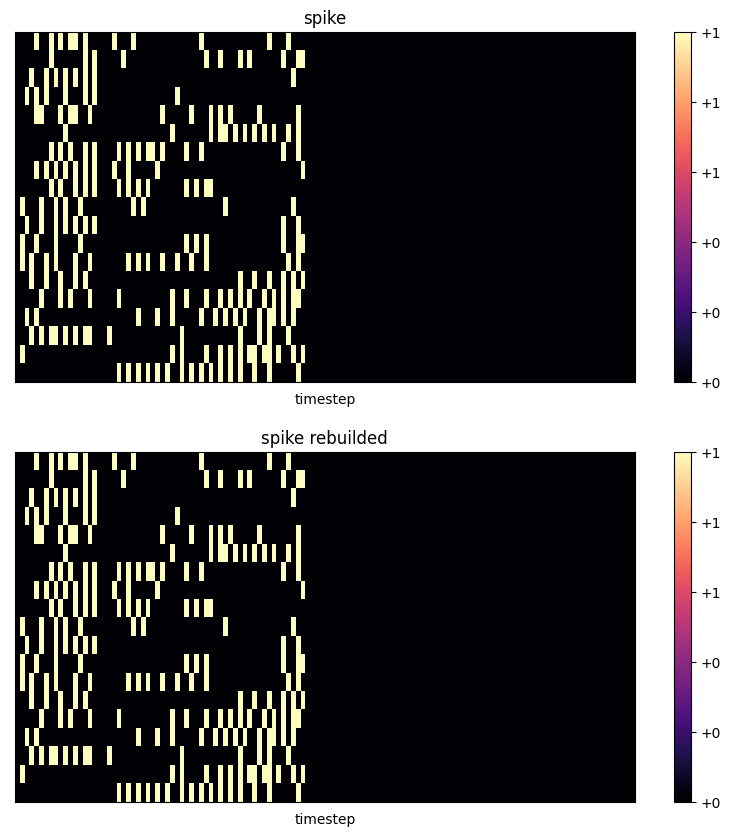

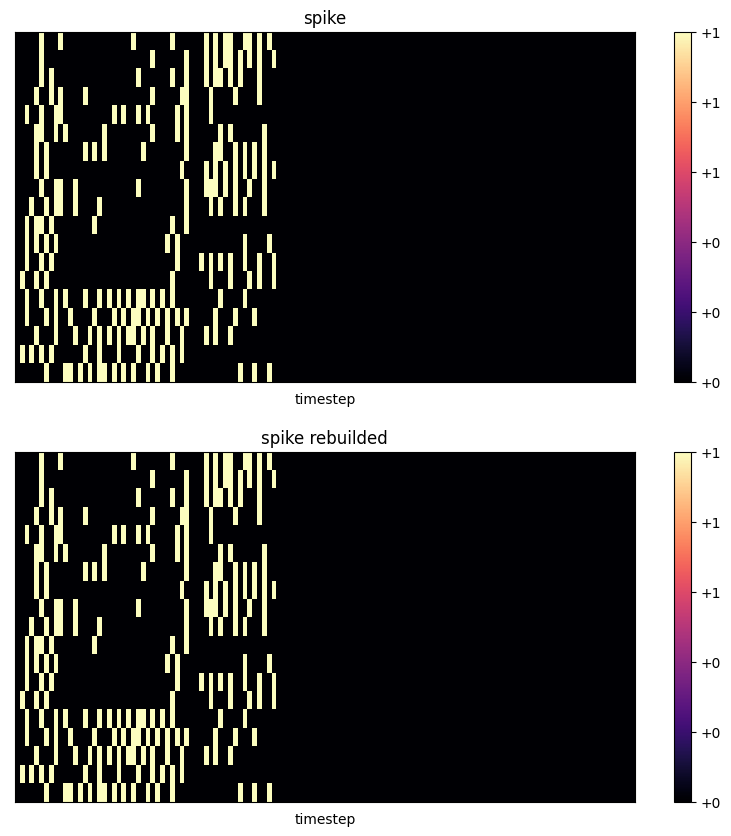

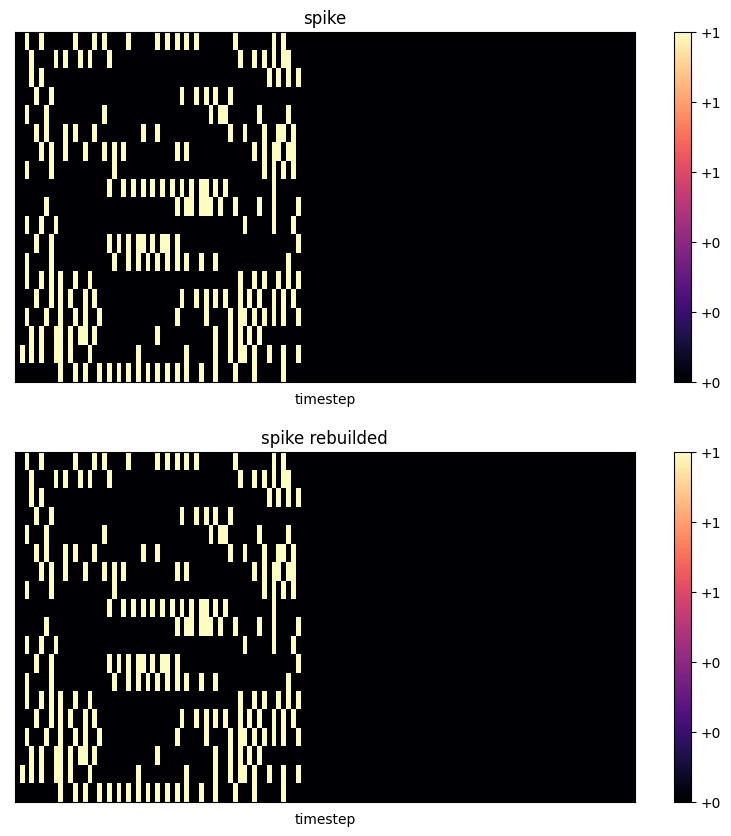

In [24]:
for i in range(0, 30000, 3000):
    spk_rebuild = AudioMNIST(DATAPATH2)[i][0][0]
    print(
        torch.sum(
            torch.ne(spks[i // 3000][i % 3000], spk_rebuild)
        ))
    
    fig, axs = plt.subplots(2, figsize=[10, 10])
    
    img = librosa.display.specshow(np.array(spks[i // 3000][i % 3000]), sr=48000, ax=axs[0])
    title3 = 'spike'
    axs[0].set_title(title3)
    axs[0].set_xlabel('timestep')
    fig.colorbar(img, ax=axs[0], format="%+2.f")

    img = librosa.display.specshow(np.array(spk_rebuild), sr=48000, ax=axs[1])
    title4 = 'spike rebuilded'
    axs[1].set_title(title4)
    axs[1].set_xlabel('timestep')
    fig.colorbar(img, ax=axs[1], format="%+2.f")

### Visualization of Dataset

In [85]:
shape = DataPreprocess(DATAPATH, spkgen=SpikeGenerator(120, 1, 3, 1, 0.9)).preprocess()

start building files!
start building data!


100%|██████████| 30000/30000 [03:27<00:00, 144.44it/s]


start storing spike files!


100%|██████████| 30000/30000 [00:17<00:00, 1728.83it/s]


In [88]:
dataset_before_read = DataPreprocess(DATAPATH, spkgen=SpikeGenerator(120, 1, 3, 1, 0.9), visualization=True)

start building files!
start building data!


100%|██████████| 30000/30000 [04:09<00:00, 120.21it/s]


(tensor([[-0.6016, -0.4213, -0.4382,  ..., -3.0000, -3.0000, -3.0000],
         [ 0.5585,  0.7486,  0.5374,  ..., -3.0000, -3.0000, -3.0000],
         [ 0.4285,  0.6394,  0.5178,  ..., -3.0000, -3.0000, -3.0000],
         ...,
         [ 2.2247,  0.0759,  1.2566,  ..., -3.0000, -3.0000, -3.0000],
         [ 2.2183, -1.5563,  1.1267,  ..., -3.0000, -3.0000, -3.0000],
         [ 0.6876, -0.9364,  0.7024,  ..., -3.0000, -3.0000, -3.0000]]),
 0)

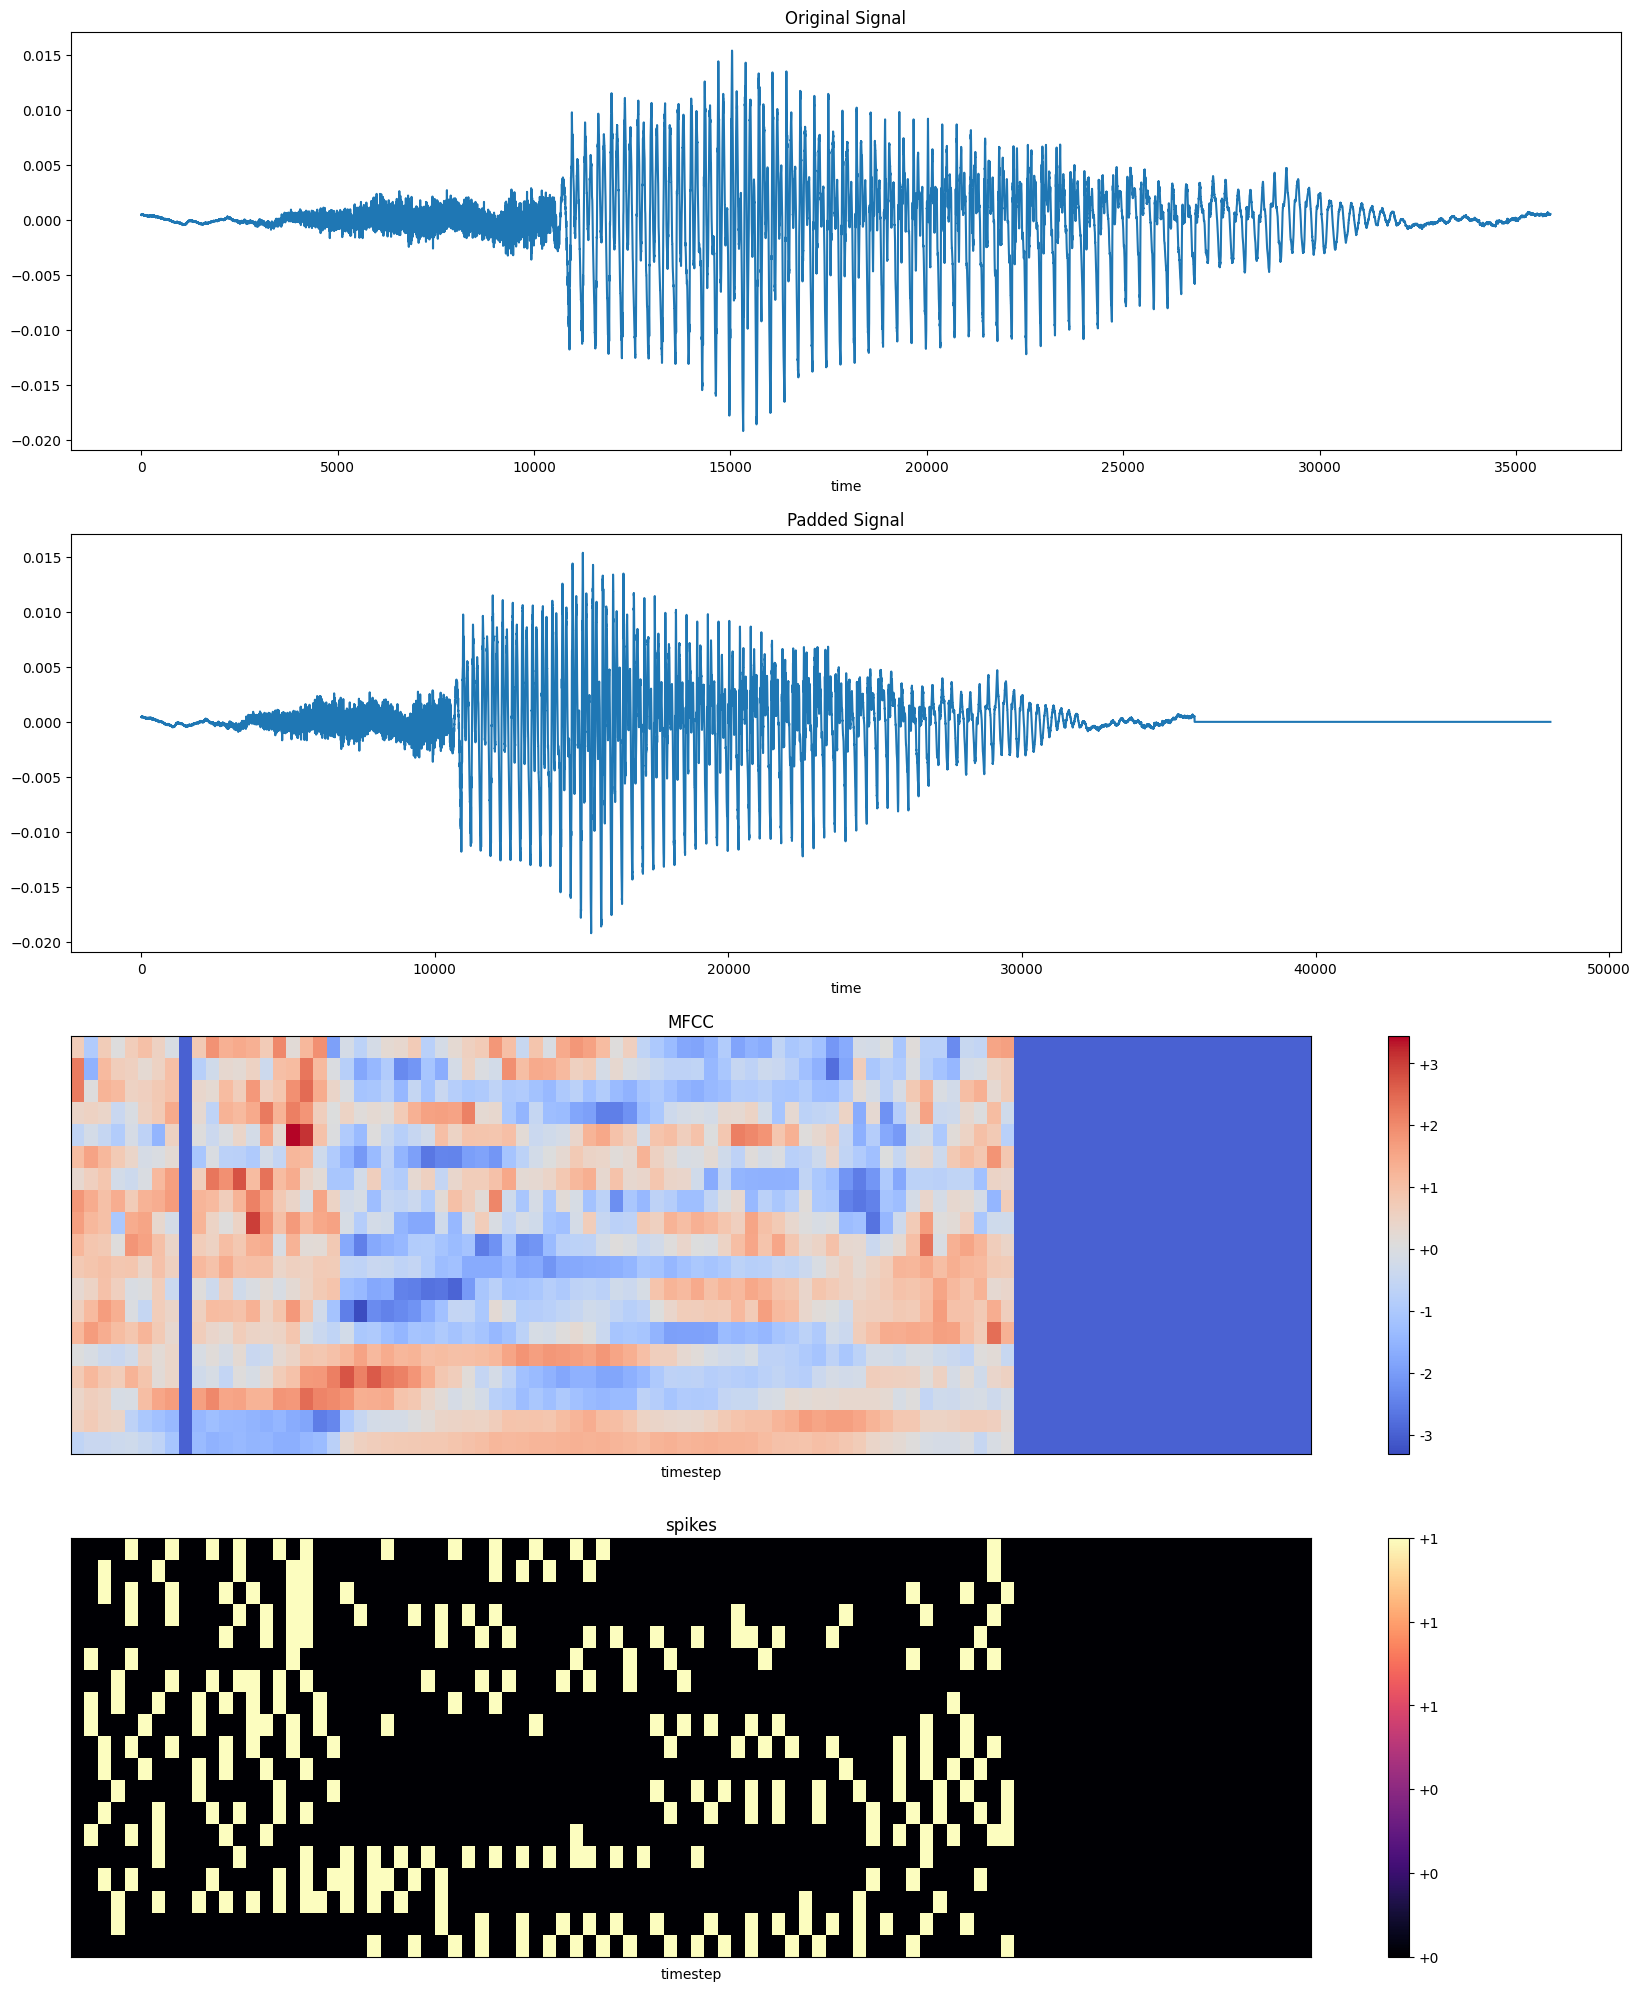

In [25]:
dataset_mfcc = AudioMNIST(DATAPATH, visualization=True,spkgen = SpikeGenerator(1,3,1,0.9), mfcc=True)
dataset_mfcc[0]

(tensor([[ 4.5075,  4.6049,  4.0730,  ...,     nan,     nan,     nan],
         [ 3.7481,  3.7692,  3.5308,  ...,     nan,     nan,     nan],
         [ 2.3010,  2.2415,  2.8259,  ...,     nan,     nan,     nan],
         ...,
         [ 0.2357,  0.2523, -0.1095,  ...,     nan,     nan,     nan],
         [ 0.3071,  0.0990,  0.1126,  ...,     nan,     nan,     nan],
         [-0.1363, -0.3610, -0.1126,  ...,     nan,     nan,     nan]]),
 0)

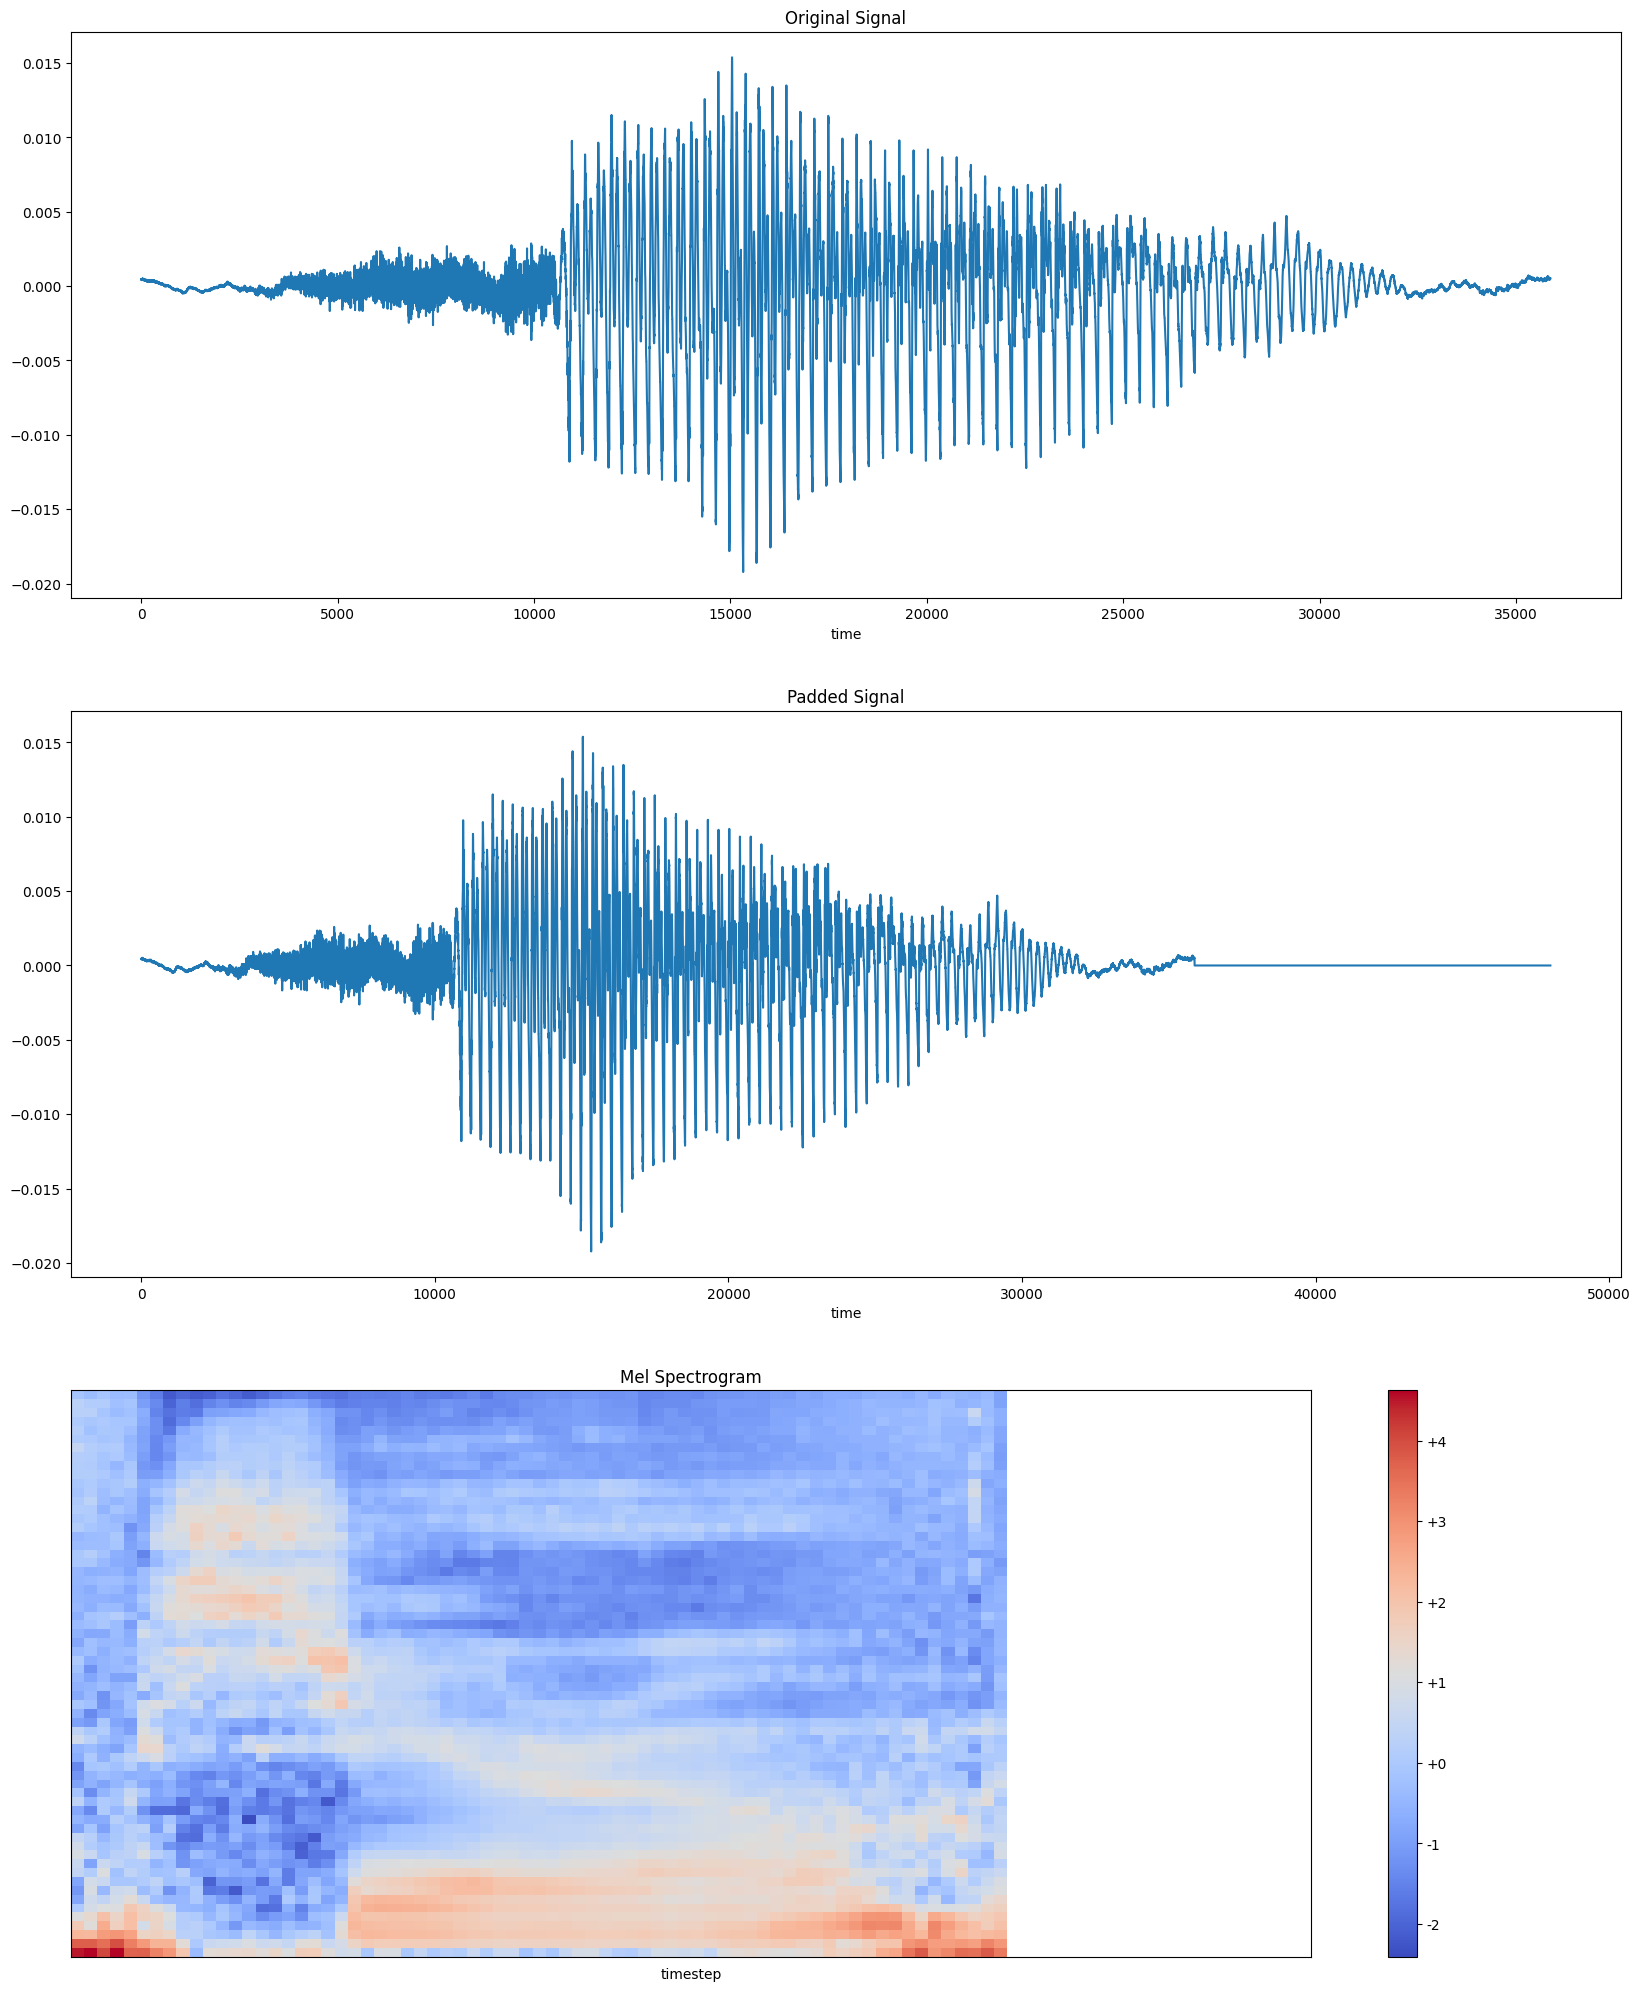

In [53]:
dataset_mel = AudioMNIST(DATAPATH, visualization=True,mfcc=False)
dataset_mel[0]

### Stats of Dataset

In [9]:
dataset_mfcc = AudioMNIST(DATAPATH,mfcc=True)
ds_mfcc = [[],[]]
for i in np.arange(len(dataset_mfcc)):
    ds_mfcc[0].append(dataset_mfcc[i][0])
    ds_mfcc[1].append(dataset_mfcc[i][1])

In [10]:
values_per_freq_mfcc = [[] for _ in range(20)]
mean_per_freq_mfcc = []
std_dev_per_freq_mfcc = []

for freq in range(20):
    for sample in ds_mfcc[0]:
        values_per_freq_mfcc[freq].append(sample[0,freq,:])
    values_per_freq_mfcc[freq] = torch.concat(values_per_freq_mfcc[freq])
    mean_per_freq_mfcc.append(torch.mean(values_per_freq_mfcc[freq]))
    std_dev_per_freq_mfcc.append(torch.std(values_per_freq_mfcc[freq]))
    
print(mean_per_freq_mfcc)
print(std_dev_per_freq_mfcc)

[tensor(-356.3612), tensor(26.2044), tensor(8.4413), tensor(9.0781), tensor(3.2324), tensor(5.5514), tensor(-2.2956), tensor(-3.2009), tensor(-2.7284), tensor(-3.5393), tensor(-3.3283), tensor(-1.6130), tensor(-2.3703), tensor(-1.2674), tensor(-3.1909), tensor(-1.3563), tensor(-2.5253), tensor(-2.4827), tensor(-2.4060), tensor(-0.8394)]
[tensor(194.6295), tensor(47.1119), tensor(23.5761), tensor(19.5492), tensor(15.3595), tensor(14.4093), tensor(12.2320), tensor(11.6191), tensor(9.5099), tensor(9.3459), tensor(8.9897), tensor(8.6923), tensor(8.1220), tensor(8.5836), tensor(7.4334), tensor(7.7912), tensor(7.5647), tensor(7.5405), tensor(6.8081), tensor(6.6348)]


In [11]:
dataset_mel = AudioMNIST(DATAPATH,mfcc=False)
ds_mel = [[],[]]
for i in np.arange(len(dataset_mfcc)):
    ds_mel[0].append(dataset_mel[i][0])
    ds_mel[1].append(dataset_mel[i][1])

In [12]:
values_per_freq_mel = [[] for _ in range(64)]
mean_per_freq_mel = []
std_dev_per_freq_mel = []

for freq in range(64):
    for sample in ds_mel[0]:
        values_per_freq_mel[freq].append(sample[0,freq,:])
    values_per_freq_mel[freq] = torch.concat(values_per_freq_mel[freq])
    mean_per_freq_mel.append(torch.mean(values_per_freq_mel[freq]))
    std_dev_per_freq_mel.append(torch.std(values_per_freq_mel[freq]))
    
print(mean_per_freq_mel)
print(std_dev_per_freq_mel)

[tensor(-40.7932), tensor(-40.2325), tensor(-41.2447), tensor(-41.7184), tensor(-42.3218), tensor(-43.2509), tensor(-43.8458), tensor(-44.8789), tensor(-45.4707), tensor(-45.9783), tensor(-47.6631), tensor(-48.6946), tensor(-49.9527), tensor(-50.5835), tensor(-51.0479), tensor(-51.5357), tensor(-51.8182), tensor(-51.9572), tensor(-51.8314), tensor(-51.5776), tensor(-51.3904), tensor(-51.1873), tensor(-51.3272), tensor(-51.4564), tensor(-51.4592), tensor(-51.3733), tensor(-51.3937), tensor(-51.4649), tensor(-51.7459), tensor(-52.1287), tensor(-52.1322), tensor(-51.9799), tensor(-51.9452), tensor(-52.3542), tensor(-52.8468), tensor(-53.3465), tensor(-53.6803), tensor(-53.9715), tensor(-54.1818), tensor(-54.1489), tensor(-53.9437), tensor(-53.7075), tensor(-53.6907), tensor(-54.0855), tensor(-54.0264), tensor(-53.7721), tensor(-53.2867), tensor(-52.9269), tensor(-53.0073), tensor(-53.2647), tensor(-53.4945), tensor(-53.5799), tensor(-53.7177), tensor(-54.3753), tensor(-54.9760), tensor(-5

### Dataloader Construction

In [172]:
class DataParam:
    def __init__(self, ratio, batch_size, shuffle):
        """
        @param ratio: the ratio of the length of subset of data to the dataset
        @param batch_size: size of the batch
        @param shuffle: T/F
        """
        self.ratio = ratio
        self.batch_size = batch_size
        self.shuffle = shuffle

In [173]:
class LoaderCreator:
    def __init__(self, datapath, num_workers=2):
        """
        @param datapath: the path to dataset
        @param num_workers:
        """
        self.num_workers = num_workers
        self.dataset = AudioMNIST(datapath)

    def create_loaders(self, train_param: DataParam, val_param: DataParam, test_param: DataParam):
        train_ds, val_ds, test_ds = random_split(self.dataset, [train_param.ratio, val_param.ratio, test_param.ratio])
        train_dl = DataLoader(train_ds,
                              batch_size=train_param.batch_size,
                              shuffle=train_param.shuffle,
                              num_workers=self.num_workers)
        val_dl = DataLoader(val_ds,
                            batch_size=val_param.batch_size,
                            shuffle=val_param.shuffle,
                            num_workers=self.num_workers)
        test_dl = DataLoader(test_ds,
                             batch_size=test_param.batch_size,
                             shuffle=test_param.shuffle,
                             num_workers=self.num_workers)
        return train_dl, val_dl, test_dl


We run dataloaders with multiple workers so that the next batch is loaded while the current batch is training. This dramatically speeds up execution and is a good way to deal with large datasets.

Note that we do not maintain the statistical properties of the dataset (i.e. a uniform distribution of the various digits). I am assuming here since we have an equal number of samples for each digit, the uniform random sampling should be fine. However for other data sets we would want to be careful with how we split the train, validation, and test sets.

In [182]:
train_param = DataParam(0.8,64,shuffle=True)
val_param = DataParam(0.12,64,shuffle=False)
test_param = DataParam(0.08,32,shuffle=False)

train_dl, val_dl, test_dl = LoaderCreator(DATAPATH).create_loaders(train_param,val_param,test_param)

In [183]:
'''
n_items = len(dataset)
n_train = round(n_items * 0.8)
n_val_test = n_items - n_train
train_ds, val_test_ds = random_split(dataset, [n_train, n_val_test])

n_val = round(n_val_test * 0.6)
n_test = n_val_test - n_val
val_ds, test_ds = random_split(val_test_ds, [n_val, n_test])

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=2
)

val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=2
)

test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=32, shuffle=False, num_workers=2
)
'''

'\nn_items = len(dataset)\nn_train = round(n_items * 0.8)\nn_val_test = n_items - n_train\ntrain_ds, val_test_ds = random_split(dataset, [n_train, n_val_test])\n\nn_val = round(n_val_test * 0.6)\nn_test = n_val_test - n_val\nval_ds, test_ds = random_split(val_test_ds, [n_val, n_test])\n\ntrain_dl = torch.utils.data.DataLoader(\n    train_ds, batch_size=64, shuffle=True, num_workers=2\n)\n\nval_dl = torch.utils.data.DataLoader(\n    val_ds, batch_size=64, shuffle=False, num_workers=2\n)\n\ntest_dl = torch.utils.data.DataLoader(\n    test_ds, batch_size=32, shuffle=False, num_workers=2\n)\n'

## Classifier Using 2D CNN on the Spectrograms

The following architecture is the one suggested in Ketan Doshi's [tutorial](https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5).

In [184]:
import torch.nn as nn

class CNN2DAudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = []
        
        def build_conv_layer(in_d, out_d, ks, stride, pad):
            conv1 = nn.Conv2d(in_d, out_d, 
                              kernel_size=(ks, ks), 
                              stride=(stride, stride), 
                              padding=(pad, pad))
            relu1 = nn.ReLU()
            bn1 = nn.BatchNorm2d(out_d)
            nn.init.kaiming_normal_(conv1.weight, a=0.1)
            conv1.bias.data.zero_()
            return [conv1, relu1, bn1]
        
        self.conv_layers += build_conv_layer(1, 8, 5, 2, 2)
        self.conv_layers += build_conv_layer(8, 16, 3, 2, 1)
        self.conv_layers += build_conv_layer(16, 32, 3, 2, 1)
        self.conv_layers += build_conv_layer(32, 64, 3, 2, 1)
        
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)
        
        self.conv = nn.Sequential(*self.conv_layers)
        
    def forward(self, x):
        x = self.conv(x)
        
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        
        return self.lin(x)

In [185]:
def evaluate(model, val_dl): 
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
        
    for data in tqdm(val_dl):
        inputs, labels = data[0].to(device), data[1].to(device)

        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))

        running_loss += loss.item()

        _, prediction = torch.max(outputs, 1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

    num_batches = len(val_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction / total_prediction

    return acc, avg_loss

In [186]:
def training(model, train_dl, val_dl, num_epochs, 
             criterion, optimizer, scheduler):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        for data in tqdm(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            optimizer.zero_grad()
            
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
            
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        
        v_acc, v_loss = evaluate(model.to(device), val_dl)
        
        print("Epoch: %d, Loss: %.4f, Train Accuracy: %.2f, Val. Loss: %.4f, Val. Accuracy: %.2f" % (
            epoch + 1, avg_loss, acc, v_loss, v_acc
        ))
        
        losses.append(avg_loss)
        val_losses.append(v_loss)
        
    return losses, val_losses

### Training the Model

In [187]:
model = CNN2DAudioClassifier().to(device)

In [188]:
N_EPOCHS = 2

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.001, 
                                                steps_per_epoch=int(len(train_dl)), 
                                                epochs=N_EPOCHS, 
                                                anneal_strategy='linear')

In [ ]:
losses, val_losses = training(model, train_dl, val_dl, N_EPOCHS, criterion, optimizer, scheduler)

In just 10 epochs our model is achieving 98% accuracy on the validation set. That is pretty good!

In [ ]:
evaluate(model, val_dl)

Our loss decreases nicely over time. With more training we could probably improve this even further.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses, range(len(val_losses)), val_losses)
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

Let's see how we do on our test set.

In [ ]:
acc, loss = evaluate(model, test_dl)
print("Test accuacy: %.2f, Test loss: %.3f" % (acc, loss))

97% on our first pass model is more than acceptable.